In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd


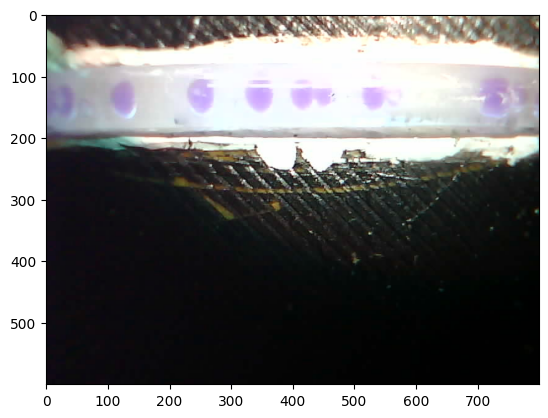

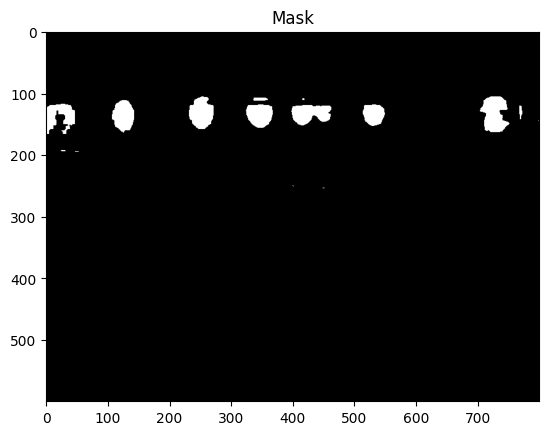

In [2]:
from utils.filefinder import getFilesFromDirectory

directory = "Gotas_01/"
list_files, list_filenames = getFilesFromDirectory(directory, ".jpg")

bgr_img = cv2.imread(list_files[32])

plt.imshow(bgr_img)
plt.show()

hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

hsv_img_blur = cv2.GaussianBlur(hsv_img, (3, 3), 0)  # Apply Gaussian blur to reduce noise

# rosa base = [169,35,90]

rosa_bajo = np.array([138, 40, 110])  
rosa_alto = np.array([178, 250, 255])  

mask = cv2.inRange(hsv_img_blur, rosa_bajo, rosa_alto)

plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

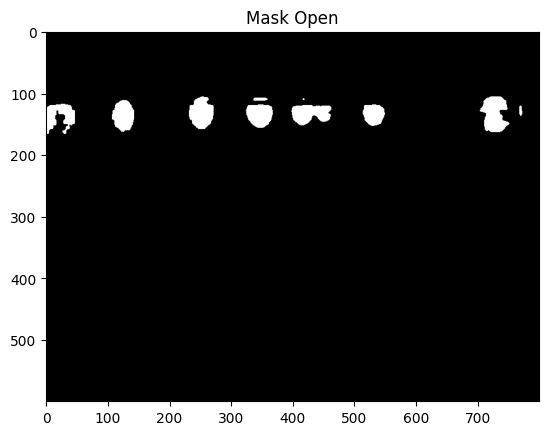

In [41]:
opening_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_kernel)

plt.imshow(mask_open, cmap='gray')
plt.title("Mask Open")
plt.show()


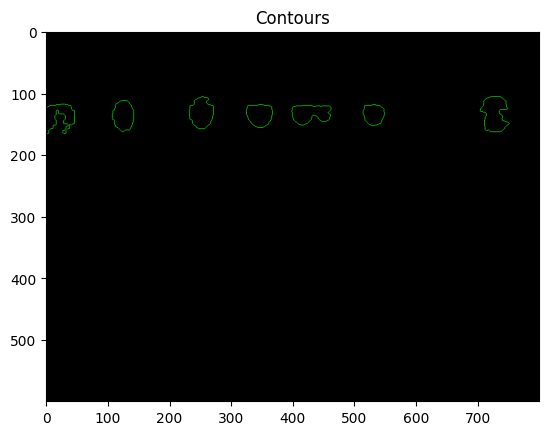

In [42]:
def getContours(base_img):

    # Calcular contornos de la imagen
    contours, _ = cv2.findContours(image=base_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    dim = np.shape(base_img)

    contours_img = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours, -1, (0,255,0), 1)
    contours_img = np.uint8(contours_img)

    return contours, contours_img

def filterContours(base_img, contours, mult=2.5, mode='DOWN'):
    # Filtrado de contornos por longitud
    contours_lenght = [len(c) for c in contours]

    cl_mean = np.mean(contours_lenght)
    cl_std = np.std(contours_lenght)

    if mode == 'DOWN':
        contours_filtered = [c for c in contours if len(c) < cl_mean + mult*cl_std]
    elif mode == 'UP':
        contours_filtered = [c for c in contours if len(c) > cl_mean + mult*cl_std]

    dim = np.shape(base_img)
    contours_filtered_img = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours_filtered, -1, (0,255,0), 1)
    contours_filtered_img = np.uint8(contours_filtered_img)

    return contours_filtered, contours_filtered_img

contours, contours_img = getContours(mask_open)
contours_filtered, contours_filtered_img = filterContours(mask_open, contours, mult=-1, mode='UP')

plt.imshow(contours_filtered_img)
plt.title("Contours")
plt.show()

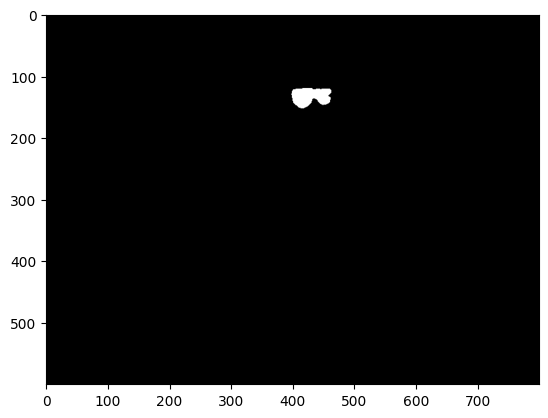

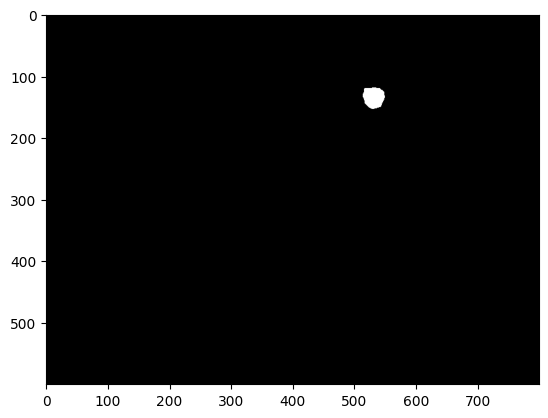

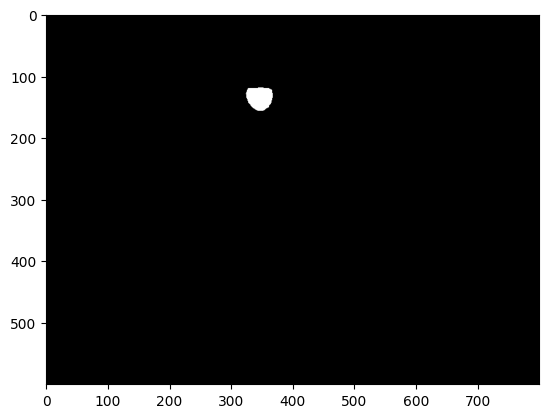

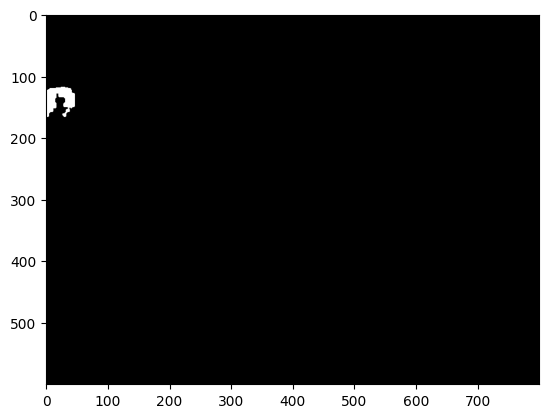

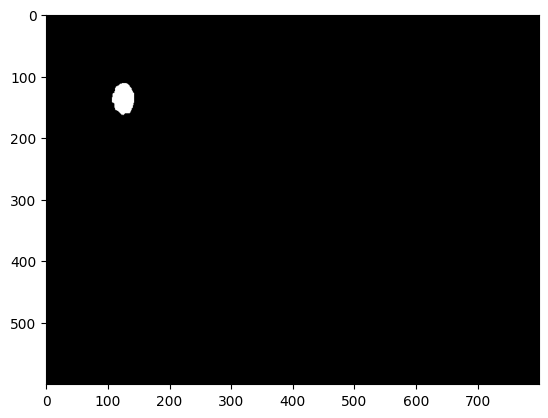

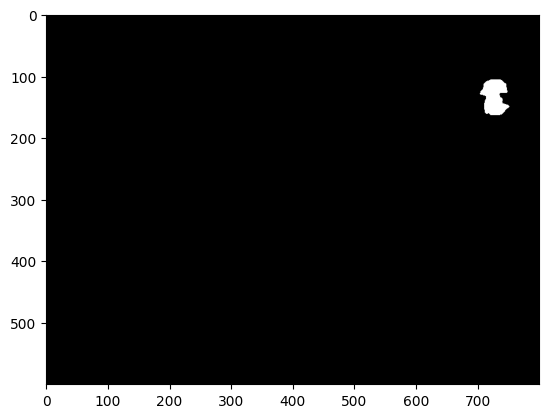

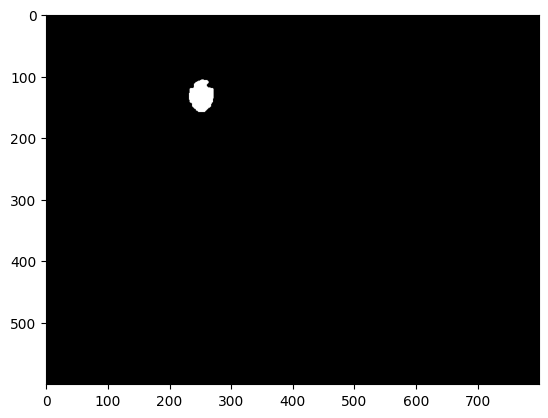

In [43]:
def getIndividualMasks(base_mask,contours):
    # Lista para guardar las máscaras individuales
    individual_masks = []
    
    # Crear una máscara por cada contorno
    for i, contour in enumerate(contours):
        # Máscara en negro (0)
        mask = np.zeros_like(base_mask, dtype=np.uint8)
        
        # Dibujar el contorno RELLENO (cv2.FILLED o thickness=-1)
        cv2.drawContours(
            image=mask,
            contours=[contour],
            contourIdx=-1,  # -1 para dibujar todos los contornos en la lista
            color=255,     # Blanco (255)
            thickness=cv2.FILLED  # Rellenar el contorno
        )
        
        individual_masks.append(mask)
    
    return individual_masks

list_individual_masks = getIndividualMasks(mask_open,contours_filtered)

for individual_maks in list_individual_masks:
    plt.imshow(individual_maks,cmap="gray")
    plt.show()


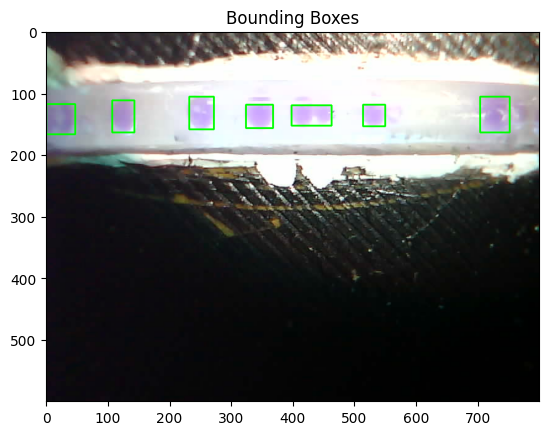

In [44]:
def getBoundingBox(mask):

    # Conversión del la máscara a clase Image
    mask_class = Image.fromarray(mask)

    # Obtención del bounding box
    bbox = mask_class.getbbox()

    # Conversión de bbox a formato utilizable
    x1,y1,x2,y2 = bbox

    bbox_coors = [(x1,y1),(x2,y2)]

    return bbox_coors

list_bboxes = [getBoundingBox(mask) for mask in list_individual_masks]

bgr_img_copy = bgr_img.copy()
for bbox in list_bboxes:
    cv2.rectangle(bgr_img_copy, bbox[0], bbox[1], (0, 255, 0), 2)

plt.imshow(bgr_img_copy)
plt.title("Bounding Boxes")
plt.show()

     file_name  bbox   x1   y1   x2   y2  width  height  bbox_area  mask_area
0  img0036.jpg     0   23  115   54  164     31      49       1519        991
1  img0036.jpg     1  103  108  218  165    115      57       6555       4425
2  img0036.jpg     2  271  115  334  155     63      40       2520       1566
3  img0036.jpg     3  483  118  560  159     77      41       3157       2338
4  img0036.jpg     4  568  123  592  149     24      26        624        349
5  img0036.jpg     5  623  116  651  143     28      27        756        472


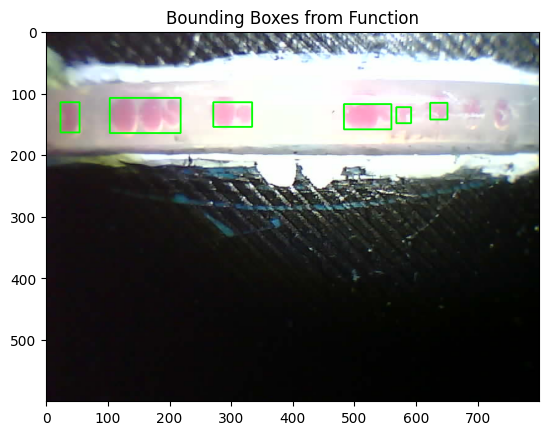

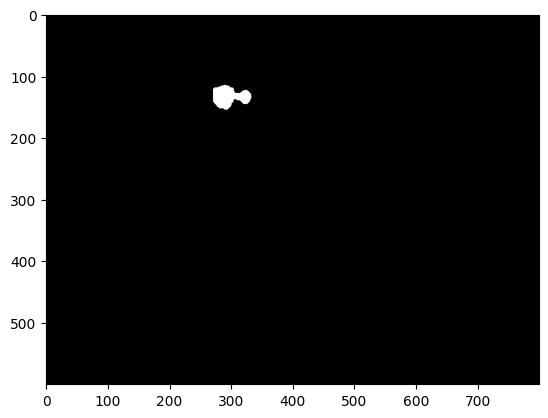

In [3]:
import imgproc.basics as ipbasics

def getBoundingBoxesForImg(bgr_img):

    # Convertir la imagen BGR a HSV
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

    # Aplicar desenfoque gaussiano para reducir el ruido
    hsv_img_blur = cv2.GaussianBlur(hsv_img, (3, 3), 0)

    # rosa base = [169,35,90]
    rosa_bajo = np.array([138, 40, 110])  
    rosa_alto = np.array([178, 250, 255])  

    # Crear una máscara para el color rosa
    mask = cv2.inRange(hsv_img_blur, rosa_bajo, rosa_alto)

    # Aplicar apertura morfológica para eliminar ruido
    opening_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_kernel)

    # Obtener contornos de la máscara
    contours, contours_img = ipbasics.getContours(mask_open)

    # Filtrar contornos por longitud
    contours_filtered, contours_filtered_img = ipbasics.filterContours(mask_open, contours, mult=-1, mode='UP')

    # Obtener máscaras individuales para cada contorno filtrado
    list_individual_masks = ipbasics.getIndividualMasks(mask_open,contours_filtered)

    print(f"Cantidad de máscaras individuales: {len(list_individual_masks)}")

    # Obtener bounding boxes para cada máscara individual
    list_bboxes = [ipbasics.getBoundingBox(mask) for mask in list_individual_masks]

    print(f"Cantidad de bounding boxes: {len(list_bboxes)}")

    # Filtrar bounding boxes por tamaño válido
    list_individual_masks_filtered = [mask for mask, bbox in zip(list_individual_masks, list_bboxes) if (bbox[0][0] - bbox[1][0])*(bbox[0][1] - bbox[1][1]) > 200]
    list_bboxes = [bbox for bbox in list_bboxes if (bbox[0][0] - bbox[1][0])*(bbox[0][1] - bbox[1][1]) > 200]

    # Ordenar la lista por x1 (primer elemento del primer punto)
    list_bboxes_sorted = sorted(list_bboxes, key=lambda bbox: bbox[0][0])
    list_individual_masks_filtered_sorted = [mask for _, mask in sorted(zip(list_bboxes, list_individual_masks_filtered), key=lambda x: x[0][0])]

    return list_bboxes_sorted, list_individual_masks_filtered_sorted

# USO DE LA FUNCIÓN getBoundingBoxesForImg

test_img = cv2.imread(list_files[35]) # Imagen BGR
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) # Convertir a RGB para matplotlib

import imgproc.bboxes as ipbboxes
bboxes, masks = ipbboxes.Bbox().getBoundingBoxesForImg(test_img,sdk=-1,minarea=200)


df = pd.DataFrame(columns=['file_name','bbox','x1', 'y1', 'x2', 'y2', 'width', 'height','bbox_area', 'mask_area'])

# Estimar cantidad de gotas en un bounding box
for i, pack in enumerate(zip(bboxes, masks)):
    
    bbox, mask = pack

    x1, y1 = bbox[0]
    x2, y2 = bbox[1]
    bbox_width = x2 - x1
    bbox_height = y2 - y1
    bbox_area = bbox_width * bbox_height
    mask_area = int(np.sum(mask) / 255)

    df.loc[len(df)] = [list_filenames[35], i, x1, y1, x2, y2, bbox_width, bbox_height, bbox_area, mask_area]

print(df)

test_img_rgb_copy = test_img_rgb.copy()
for bbox in bboxes:
    cv2.rectangle(test_img_rgb_copy, bbox[0], bbox[1], (0, 255, 0), 2)

plt.imshow(test_img_rgb_copy)
plt.title("Bounding Boxes from Function")
plt.show()

plt.imshow(masks[2], cmap='gray')
plt.show()

    

In [4]:
new_df = ipbboxes.Bbox().getDataFrameForImg(list_files[35], list_filenames[35], sdk=-1, minarea=200)
print(new_df)

     file_name  bbox   x1   y1   x2   y2  width  height  bbox_area  mask_area
0  img0036.jpg     0   23  115   54  164     31      49       1519        991
1  img0036.jpg     1  103  108  218  165    115      57       6555       4425
2  img0036.jpg     2  271  115  334  155     63      40       2520       1566
3  img0036.jpg     3  483  118  560  159     77      41       3157       2338
4  img0036.jpg     4  568  123  592  149     24      26        624        349
5  img0036.jpg     5  623  116  651  143     28      27        756        472


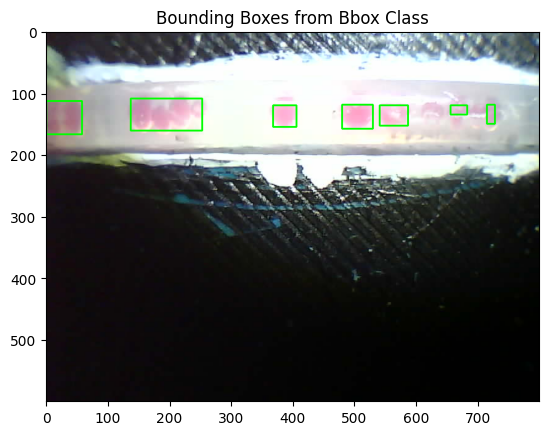

In [2]:
from imgproc.bboxes import Bbox
from utils.filefinder import getFilesFromDirectory

directory = "Gotas_01/"
list_files, list_filenames = getFilesFromDirectory(directory, ".jpg")

# USO DE LA CLASE Bbox
img_with_bbox, list_bboxes = Bbox().getImgWithBboxes(list_files[50],sdk=-1,minarea=250)

plt.imshow(img_with_bbox)
plt.title("Bounding Boxes from Bbox Class")
plt.show()

In [12]:
print(np.shape(img_with_bbox))

(600, 800, 3)


In [3]:
list_img_with_bboxes = []
for file in list_files:
    img_with_bbox, bboxes = Bbox().getImgWithBboxes(path_img=file,sdk=-1,minarea=250)
    list_img_with_bboxes.append(img_with_bbox)

c:\Users\Lucas\miniconda3\envs\imgproc\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Lucas\miniconda3\envs\imgproc\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Lucas\miniconda3\envs\imgproc\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Lucas\miniconda3\envs\imgproc\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Lucas\miniconda3\envs\imgproc\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
# Configuración del video
output_path = "bbox_video_2.mp4"  # Nombre del archivo de salida
fps = 5  # Cuadros por segundo (ajusta según necesites)
frame_size = (800, 600)  # Tamaño del video (ancho, alto). ¡Debe coincidir con tus imágenes!

# Inicializar VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Códec para MP4 (alternativa: 'XVID' para AVI)
video_writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

for frame in list_img_with_bboxes:
    # Escribir el frame en el video
    video_writer.write(frame)

# Liberar recursos
video_writer.release()